In [1]:
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from spikeHelper.dataOrganization import trialToXyT,getX,XyTfromEpoch, normRows
import pickle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from spikeHelper.similarities import MahalanobisClassifier, temporalGeneralization,crossGeneralization
%matplotlib inline

In [27]:
from spikeHelper.dataOrganization import loadBestParams
from sklearn.svm import SVC
from spikeHelper.metrics import performanceFromConfusion
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
def decoderPerformancePlot(wrapperBeg, wrapperEnd, rat, axs=[]):
    parameters = loadBestParams(rat)

    if len(axs)==0:
        fig, axs=plt.subplots(5,1)
        fig.set_size_inches((5,20))
        
    ax=axs[0]; axGenBeg=axs[1]; axGenEnd=axs[2]; axNormGenBeg=axs[3]; axNormGenEnd=axs[4];
    
    clf = LogisticRegression()#SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(wrapperBeg.X, wrapperBeg.y, wrapperBeg.trial, clf,returnCubic=True)
    begDirect = performanceFromConfusion(aux,kind='kappa')
   
    clf = LogisticRegression()#SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(wrapperEnd.X, wrapperEnd.y, wrapperEnd.trial, clf,returnCubic=True)
    endDirect = performanceFromConfusion(aux,kind='kappa')

    aux, tGen = crossGeneralization(wrapperBeg,wrapperEnd,rat)
    endTestCross = performanceFromConfusion(aux,kind='kappa')
    axGenEnd.imshow(tGen,origin='bottom',cmap='viridis'); axGenEnd.set_title('Test end')
    axGenEnd.set_xlabel('Real') ; axGenEnd.set_ylabel('Predicted')
    axNormGenEnd.imshow(aux.mean(axis=2),origin='bottom',cmap='viridis'); axNormGenEnd.set_title('Test beg Normalized rows')
    

    
    aux, tGen = crossGeneralization(wrapperEnd,wrapperBeg,rat)
    begTestCross = performanceFromConfusion(aux,kind='kappa')
    axGenBeg.imshow(tGen,origin='bottom',cmap='viridis'); axGenBeg.set_title('Test beg')
    axGenBeg.set_xlabel('Real') ; axGenBeg.set_ylabel('Predicted')
    axNormGenBeg.imshow(aux.mean(axis=2),origin='bottom',cmap='viridis'); axNormGenBeg.set_title('Test beg Normalized rows')

    
    ax.plot([0,1],[begDirect,endDirect], 'r-o', label='Direct')
    ax.plot([0,1],[begTestCross,endTestCross],'b-o', label='Cross')
    ax.legend(loc='upper right'); ax.set_xticks([0,1],['Beg','End']); ax.set_ylim([0,1])

    [ax.set_aspect(aspect= 'auto') for ax in axs]
    return begDirect

def crossGeneralization(epochsTrain,epochsTest,rat):
    '''Trains on all of the first input, and tests in each of the second'''
    Xtrain, ytrain = epochsTrain.X, epochsTrain.y
    Xtest, ytest = epochsTest.X, epochsTest.y
    ytrial = epochsTest.trial


    parameters = loadBestParams(rat)
    clf = SVC(C=parameters['C'], gamma=10**parameters['logGamma'], decision_function_shape='ovr')
    clf.fit(Xtrain,ytrain)

    allclasses = np.unique(np.hstack((ytest,ytrain)))
    n_classes = len(allclasses)
    
    trials = np.unique(epochsTest.trial)
    confusionPerTrial = np.full((n_classes,n_classes,trials.shape[0]), 0)
    for i,testTrial in enumerate(np.unique(ytrial)):
        ypred = clf.predict(Xtest[ytrial==testTrial, :])

        confusionPerTrial[:,:,i] = confusion_matrix(ytest[ytrial==testTrial], ypred,labels=allclasses)

    ntrain, ntest = len(np.unique(ytrain)), len(np.unique(ytest))
    tempGen = np.full((ntrain,ntest),np.nan)
    for real_y in np.unique(ytest):
        tempGen[:,real_y-min(allclasses)] = clf.decision_function(Xtest[ytest==real_y]).mean(axis=0)

    return confusionPerTrial,tempGen

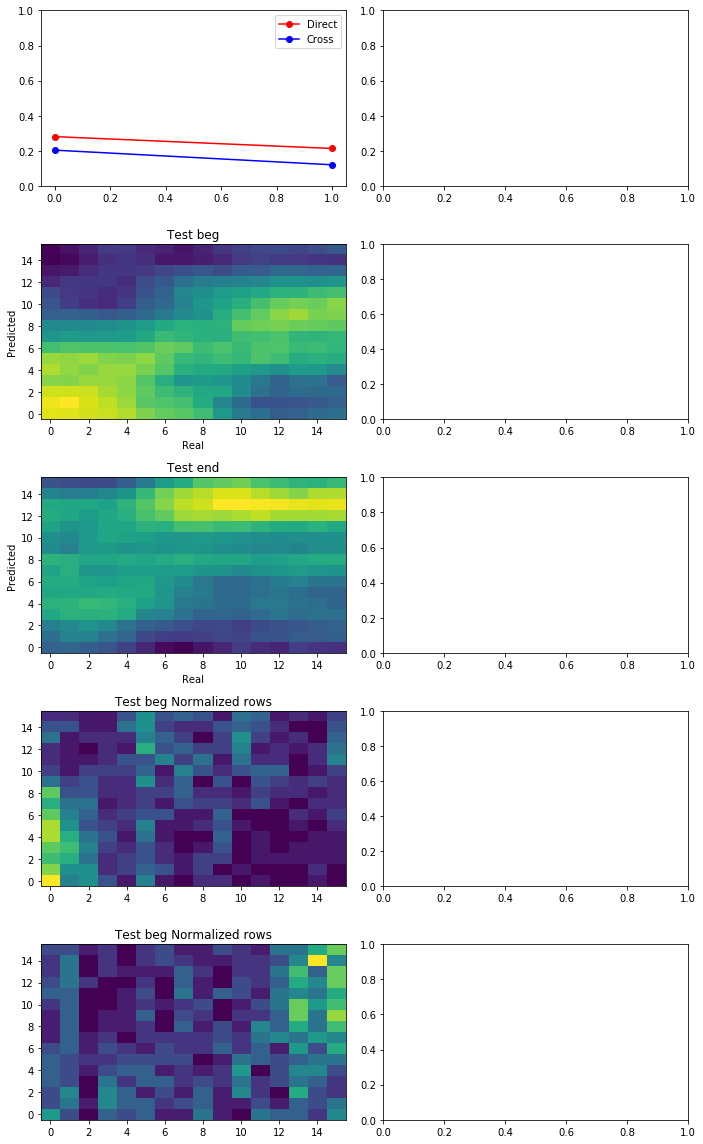

In [28]:
from spikeHelper.loadSpike import Rat
rat = 9
beg = Rat(rat,binSize=50); beg.selecTrials({'minDuration':1400,'maxDuration':4000,'ntrials':50}); 
beg.selecTimes(tmin = 200, tmax=1000)
end = Rat(rat,binSize=50); end.selecTrials({'minDuration':1400,'maxDuration':4000,'trialMin':300,'ntrials':50});
end.selecTimes(tmin = 200, tmax=1000)

fig , axs = plt.subplots(5,2) 
fig.set_size_inches((10,16))
decoderPerformancePlot(beg,end,rat,axs[:,0])

#decoderPerformancePlot(trialToXyT(short[:,:,-50:]),trialToXyT(long[:,:,-50:]),rat,axs[:,1])


plt.tight_layout()

Minimum size not restricted. Using all up from  12
Maximum size restricted. Using all up to  36
Minimum size restricted. Using all up from  56
Maximum size not restricted. Using all up to  222


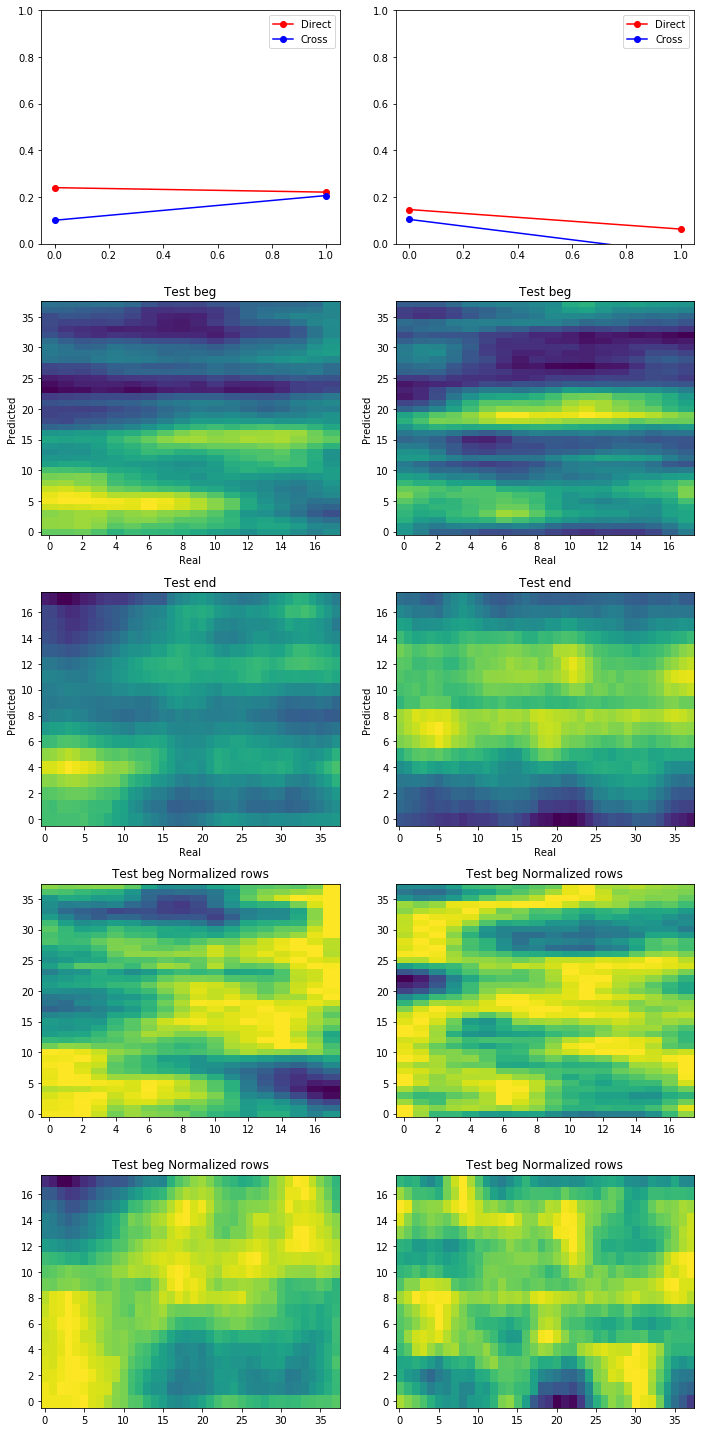

In [10]:
rat = 7
data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))

short, trialShort = XyTfromEpoch(data,getBins=[12,30],maxBins=36,verbose=True,returnTrialN=True)

long, trialLong= XyTfromEpoch(data,getBins=[12,50],minBins=56,verbose=True,returnTrialN=True)

fig , axs = plt.subplots(5,2) 
fig.set_size_inches((10,20))
decoderPerformancePlot(trialToXyT(short[:,:,:50]),trialToXyT(long[:,:,:50]),rat,axs[:,0])

decoderPerformancePlot(trialToXyT(short[:,:,-50:]),trialToXyT(long[:,:,-50:]),rat,axs[:,1])


plt.tight_layout()

In [10]:
from spikeHelper.loadSpike import Rat
from spikeHelper.dataOrganization import loadBestParams
from sklearn.svm import SVC
from spikeHelper.metrics import performanceFromConfusion
from sklearn.metrics import confusion_matrix

In [38]:
rat = 8
data = Rat(rat,binSize=50); 
data.selecTrials({'minDuration':1800,'ntrials':100})

data.selecTimes(tmin=200,tmax=1500)
data.describe()

Label: Rat 8
Bin size: 50
Sigma: 100

Using 100 trials, according to following restrictions:
minDuration: 1800
ntrials: 100

Using 26 time bins:
From 200 to 250ms
From 250 to 300ms
From 300 to 350ms
.
.
.
From 1400 to 1450ms
From 1450 to 1500ms


In [39]:
parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
aux = temporalGeneralization(data.X, data.y, data.trial, clf,returnDecisionFunc=True,returnCubic=True)

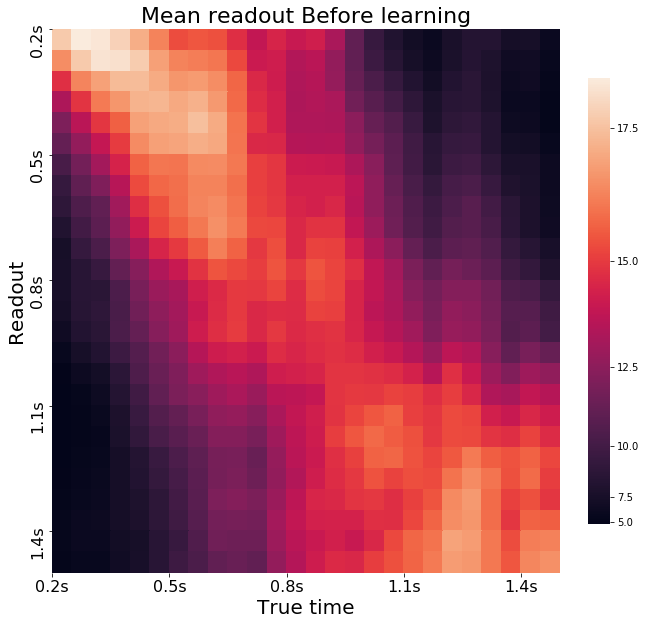

In [40]:
import seaborn as sns
plt.figure(figsize=(10,10))
from matplotlib import colors
sns.heatmap(aux.mean(axis=2),norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04})
plt.title('Mean readout Before learning',fontsize=22)
xt = np.arange(0,aux.shape[0]+4,6)
plt.xticks(xt,map(lambda x: str((x)*.05+.2)+'s',xt),fontsize=16)
plt.yticks(xt,map(lambda x: str((x)*.05+.2)+'s',xt),fontsize=16)
plt.xlabel('True time',fontsize=20);
plt.ylabel('Readout',fontsize=20);

In [12]:
def heatAct(data,ax):
    meanAct = np.nan_to_num(normRows(np.mean(data, axis=2)))
    order = np.argsort(np.nonzero(meanAct==1)[1])
    ax.imshow(meanAct[order,:],cmap='magma',origin='bottom')
    ax.set_yticks([],[]);ax.set_xticks([],[])
    ax.set_aspect(aspect= 'auto')

def pcPlot(beg,end,axg,axp):
    
    X, y = getX(beg), beg['y']
    pcs, exp= getMeanPC(X,y)
    for i,pc in enumerate(pcs):
        axg.plot(pc,'y', alpha=.05+ .95*(exp[i])/max(exp),linewidth=1+2*(exp[i]))
    axp.plot(np.cumsum(exp),'y',label='Beg. Dim: %d'%dim(exp))
    
    
    X, y = getX(end), end['y']
    pcs, exp = getMeanPC(X,y)
    for i,pc in enumerate(pcs):
        axg.plot(pc,'b', alpha=(exp[i])/max(exp),linewidth=1+2*(exp[i]))
    axp.plot(np.cumsum(exp),'b',label='End. Dim: %d'%dim(exp))
    
    axp.set_yticks([],[]);axp.set_xticks([],[])
    axp.legend(loc='lower right',markerscale=8,fontsize=8)
    axg.set_title('Componentes principais no tempo')
    
    
    
def getMeanPC(X,y):
    pca = PCA()
    pca.fit(X)
    endPca =[ pca.transform(X[y==i]) for i in range(max(y)+1)]
    pcs = np.array(list(map(lambda x: x.mean(axis=0), endPca))).transpose()
    exp = pca.explained_variance_ratio_
    return pcs, exp

def dim(explained_ratio):
    return np.nonzero(np.cumsum(explained_ratio)>.95)[0][0]

In [13]:
def removeTrialsWithMuchActivity(unitTimeTrialCubic, devs = 2):
    trialActivity = unitTimeTrialCubic.sum(axis=1).mean(axis=0)
    base = np.median(trialActivity)
    threshold = base + devs*trialActivity.std()
    print('Removing %d trials' %(trialActivity > threshold).sum())
    
    return unitTimeTrialCubic[:,:,trialActivity < threshold]

def removeNeuronsThatDoNotFire(unitTimeTrialCubic,threshold = 10):
    trialActivity = unitTimeTrialCubic.mean(axis=2).sum(axis=1)
    print('Removing %d neurons' %(trialActivity < threshold).sum())
    
    return unitTimeTrialCubic[trialActivity > threshold,:,:]

In [14]:
from sklearn.covariance import EmpiricalCovariance
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance

def plotCovariance(data,ax):
    empCov = EmpiricalCovariance()
    empCov.fit(getX(data))
    ax.imshow(empCov.covariance_,cmap='cool')
    
def plotCovariance2(data,ax):
    cov = Covariances()
    cov = cov.transform(data.transpose().swapaxes(1,2))
    ax.imshow(cov.mean(axis=0),cmap='cool')

Minimum size restricted. Using all up from  40
Maximum size restricted. Using all up to  75
(29, 26, 588)


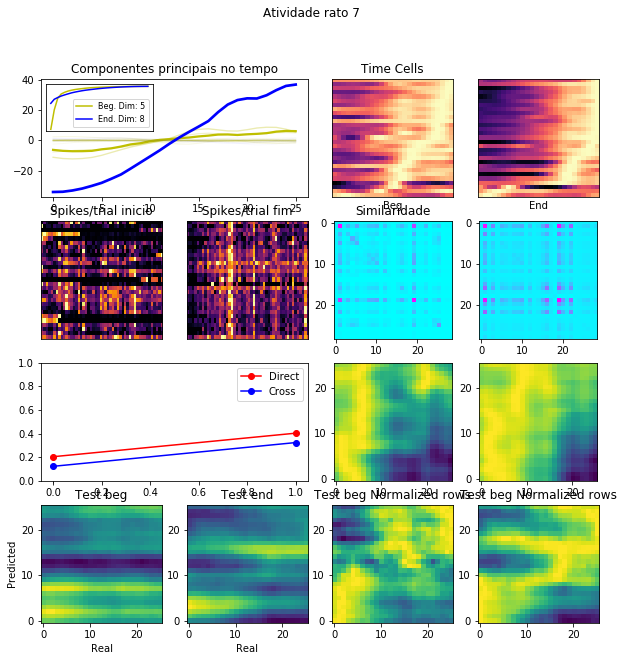

In [26]:
def intPlot(beg, end,rat, performance = True):
    fig=plt.figure(figsize=(10,10))
    grid = plt.GridSpec(4,4)

    begE, endE = trialToXyT(beg), trialToXyT(end)
    
    # Principal components
    axg = plt.subplot(grid[0,0:2])
    axp = inset_axes(axg,height="40%",width="40%",loc=2)
    pcPlot(begE,endE,axg,axp)
    
    # Time cells
    axp2= plt.subplot(grid[0,2])
    axp3= plt.subplot(grid[0,3])

    
    heatAct(beg,axp2);axp2.set_xlabel('Beg')#set_title('Beg')
    heatAct(end,axp3);axp3.set_xlabel('End')#set_title('End')
    axp2.set_title('Time Cells')
    
    # Spikes per trial inicio
    axp4= plt.subplot(grid[1,0])
    axp4.imshow(normRows(beg.mean(axis=1)),cmap='inferno',origin='bottom')
    axp4.set_yticks([],[]);axp4.set_xticks([],[]);
    axp4.set_aspect(aspect= 'auto')
    axp4.set_title('Spikes/trial inicio')
    
    # Spikes per trial fim
    axp4= plt.subplot(grid[1,1])
    axp4.imshow(normRows(end.sum(axis=1)),cmap='inferno',origin='bottom')
    axp4.set_yticks([],[]);axp4.set_xticks([],[]);
    axp4.set_aspect(aspect= 'auto')
    axp4.set_title('Spikes/trial fim')
    
    # Similaridade mahalanobis começo
    tgenBeg = plt.subplot(grid[1,2])
    clf=MahalanobisClassifier(warm_start=True)
    sim = temporalGeneralization(getX(begE),begE['y'],begE['trial'],clf,transform=True)
    tgenBeg.imshow(sim,origin='bottom');#tgenBeg.set_yticks([],[]);tgenBeg.set_xticks([],[]);
    tgenBeg.set_title('Similaridade')
    # Normalizada
    tgenBegNorm = plt.subplot(grid[2,2])
    tgenBegNorm.imshow(normRows(sim),origin='bottom')
    
    # Similaridade mahalanobis fim
    tgenEnd = plt.subplot(grid[1,3])
    clf=MahalanobisClassifier(warm_start=True)
    sim = temporalGeneralization(getX(endE), endE['y'], endE['trial'], clf,transform=True)
    tgenEnd.imshow(sim,origin='bottom');#tgenEnd.set_yticks([],[]);tgenEnd.set_xticks([],[]);
    # Normalizada
    tgenEndNorm = plt.subplot(grid[2,3])
    tgenEndNorm.imshow(normRows(sim),origin='bottom')
    
    # Covariancia
    plotCovariance2(beg,plt.subplot(grid[1,2]))
    plotCovariance2(end,plt.subplot(grid[1,3]))
    
    if performance:
        perf = plt.subplot(grid[2,0:2])
        axGenEnd = plt.subplot(grid[3,1])
        axGenBeg = plt.subplot(grid[3,0])
        axNormGenBeg = plt.subplot(grid[3,2])
        axNormGenEnd = plt.subplot(grid[3,3])
        decoderPerformancePlot(begE, endE, rat, [perf,axGenBeg,axGenEnd,axNormGenBeg,axNormGenEnd])
    
    fig.suptitle('Atividade rato %d'%rat)
    
    #grid.tight_layout(fig)


rat = 7
data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
data = XyTfromEpoch(data,getBins=[10,36],minBins=40,maxBins=75,verbose=True)[:,0:,:]
#data = removeTrialsWithMuchActivity(data,devs=2)
#data = removeNeuronsThatDoNotFire(data, threshold=20)
print(data.shape)
fig=plt.figure(figsize=[14,3])
intPlot(data[:,:,:50],data[:,:,150:200],rat,performance=True)

Minimum size not restricted. Using all up from  12
Maximum size restricted. Using all up to  36
Minimum size restricted. Using all up from  56
Maximum size not restricted. Using all up to  222


TypeError: decoderPerformancePlot() takes from 3 to 4 positional arguments but 8 were given

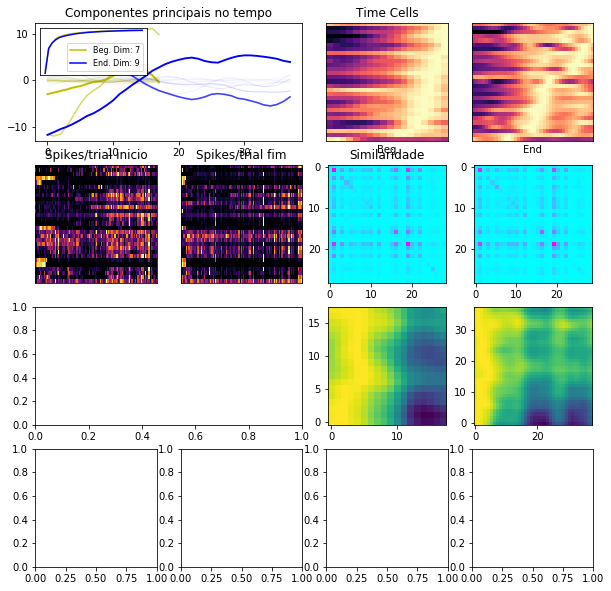

In [16]:
rat = 7
data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
short = XyTfromEpoch(data,getBins=[12,30],maxBins=36,verbose=True)[:,:,:100]
#short = removeTrialsWithMuchActivity(short,devs=2)

long = XyTfromEpoch(data,getBins=[12,50],minBins=56,verbose=True)[:,:,:100]
#long = removeTrialsWithMuchActivity(long,devs=2)

fig=plt.figure(figsize=[14,3])
intPlot(short,long,rat,performance=True)

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    plt.subplot(4,1,rat-6)
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,36],minBins=40,verbose=True)[:,4:20,:]
    plt.plot(data.sum(axis=1).mean(axis=0))
    plt.fill_between(np.arange(data.shape[2]),np.median(data.sum(axis=1).mean(axis=0))+2*data.sum(axis=1).mean(axis=0).std(),alpha=.3)

---

In [11]:
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
sne = TSNE()

In [12]:
interm = lda.fit_transform(data['X'],data['y'])

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [13]:
interm.shape

(12680, 19)

In [ ]:
visual = sne.fit_transform(data['X'],data['y'])

In [ ]:
cm = plt.get_cmap('inferno')
NUM_COLORS = 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for time in range(8):
    plt.plot(visual[data['y']==time,0],visual[data['y']==time,1],'.')